In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from pandas.api.types import CategoricalDtype
from plotnine import ggplot, aes, geom_line, labs, theme, facet_wrap, scale_color_manual
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)

In [2]:
df = pd.read_csv('../data/ground_station.csv')
df1 = pd.read_csv('../data/ground_station_1.csv')
df = pd.concat([df, df1], axis=0)
df = df.drop("Created_at",axis=1)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Timestamp'] = df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert('Etc/GMT-12')
df = df.sort_values('Timestamp').reset_index(drop=True)
df = df.set_index('Timestamp')
df.index = df.index.tz_localize(None)

In [3]:
data_inicio = '2024-06-01'
data_fim = '2025-12-30'
df = df.loc[data_inicio:data_fim]
df = df.resample('h').mean()

In [4]:
df.describe()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
count,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000
mean,-119.523947,49.903098,12.806548,82.425794,0.063761,0.840232,101.099537,7498.807026,12.737226
std,0.064511,0.015856,6.483927,14.834284,2.612332,1.131064,106.454851,1324.014264,6.977878
min,-119.700698,49.859654,-1.575000,15.558333,0.000000,0.000000,0.000000,5339.636364,-0.170000
25%,-119.591264,49.886552,8.526042,77.417708,0.000000,0.000000,0.000000,6273.333333,8.736146
50%,-119.481830,49.913450,11.381458,86.160417,0.000000,0.228958,74.833333,7897.333333,10.819583
75%,-119.481830,49.913450,16.831563,92.184375,0.000000,1.411667,193.541667,8697.166667,16.068125
max,-119.481830,49.913450,38.842500,100.000000,143.425329,7.330417,347.250000,9854.666667,49.478333


In [5]:
print(f"df.index.max(): {df.index.max()}")
print(f"df.index.min(): {df.index.min()}")

df.index.max(): 2025-05-13 04:00:00
df.index.min(): 2024-06-01 00:00:00


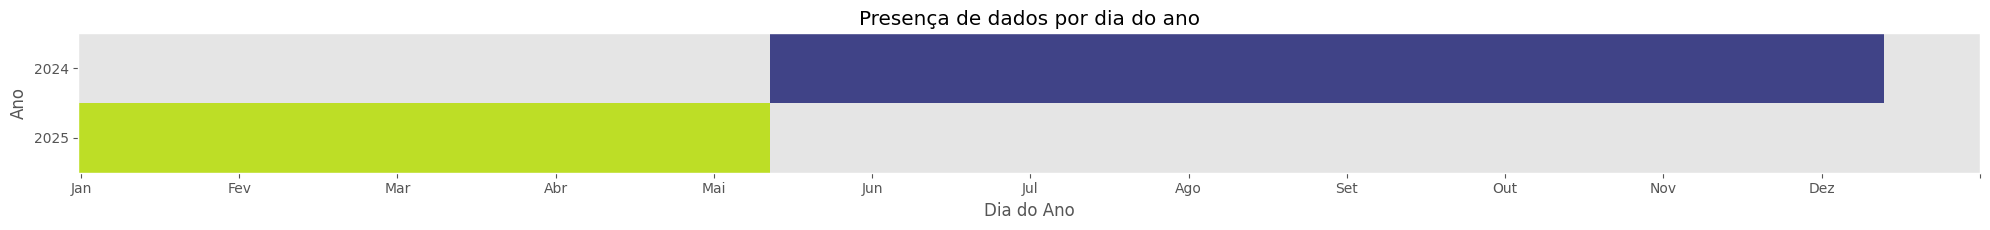

In [6]:
presence = pd.Series(1, index=df.index)
presence = presence.resample('D').max()

# Create DataFrame with date info
presence_df = presence.to_frame('present')
presence_df['year'] = presence_df.index.year
presence_df['day_of_year'] = presence_df.index.dayofyear

# Create presence matrix by year x day
matrix = presence_df.pivot(index='year', columns='day_of_year', values='present')

# Create colormap with one color per year
years = matrix.index
n_years = len(years)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, n_years))
cmap = mcolors.ListedColormap(colors)
data_colored = np.array([
    row * i if not np.all(np.isnan(row)) else np.nan
    for i, row in enumerate(matrix.values, start=1)
])

# Plotar
plt.figure(figsize=(20, n_years * 1.2))
plt.imshow(data_colored, aspect='auto', cmap=cmap, interpolation='none')
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.title('Data presence by day of year')
plt.xticks(np.linspace(0, 365, 13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',''])
plt.yticks(ticks=np.arange(len(years)), labels=years)
plt.grid(False)
plt.tight_layout()
plt.show()

In [7]:
decomps = {}
residuals = pd.DataFrame(index=df.index)
for col in df.columns:
    if col == 'Timestamp':
        continue
    stl_res = STL(df[col], period=24, robust=True).fit()
    decomps[col] = stl_res
    residuals[col] = stl_res.resid

In [8]:
iso = IsolationForest(contamination='auto', random_state=42)
iso.fit(residuals)

IsolationForest(random_state=42)

In [9]:
flags = iso.predict(residuals)
is_multivariate_anomaly = pd.Series(flags == -1, index=residuals.index)
df['is_multivariate_anomaly'] = is_multivariate_anomaly
df.head()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature,is_multivariate_anomaly
Timestamp,,,,,,,,,,
2024-06-01 00:00:00,-119.591264,49.886552,3.360417,93.850000,0.0,2.058333,292.333333,9123.333333,3.805833,False
2024-06-01 01:00:00,-119.591264,49.886552,7.297917,89.512500,0.0,1.539167,152.416667,9100.666667,5.378750,False
2024-06-01 02:00:00,-119.591264,49.886552,9.898333,83.608333,0.0,1.136250,100.833333,9092.000000,8.674167,False
2024-06-01 03:00:00,-119.591264,49.886552,12.027917,75.337500,0.0,2.122917,170.291667,9110.000000,12.669167,False
2024-06-01 04:00:00,-119.591264,49.886552,14.480833,69.791667,0.0,2.089167,180.083333,9132.666667,15.624583,False


In [10]:
print('Found {} outliers'.format(is_multivariate_anomaly.sum()))

Foram encontrados 276 outliers


In [11]:
df_clean = df.copy()
for col, stl_res in decomps.items():
    cleaned_series = df[col].copy()
    cleaned_series[is_multivariate_anomaly] = (stl_res.trend + stl_res.seasonal)[is_multivariate_anomaly]
    df_clean[col] = cleaned_series
df_clean.drop(columns=['is_multivariate_anomaly'], inplace=True)
df.drop(columns=['is_multivariate_anomaly'], inplace=True)
df_clean.head()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
Timestamp,,,,,,,,,
2024-06-01 00:00:00,-119.591264,49.886552,3.360417,93.850000,0.0,2.058333,292.333333,9123.333333,3.805833
2024-06-01 01:00:00,-119.591264,49.886552,7.297917,89.512500,0.0,1.539167,152.416667,9100.666667,5.378750
2024-06-01 02:00:00,-119.591264,49.886552,9.898333,83.608333,0.0,1.136250,100.833333,9092.000000,8.674167
2024-06-01 03:00:00,-119.591264,49.886552,12.027917,75.337500,0.0,2.122917,170.291667,9110.000000,12.669167
2024-06-01 04:00:00,-119.591264,49.886552,14.480833,69.791667,0.0,2.089167,180.083333,9132.666667,15.624583


In [12]:
print('--- Original ---')
print(df.describe())
print('--- Cleaned ---')
print(df_clean.describe())

--- Original ---
         Longitude     Latitude  Temperature     Humidity  Precipitation  \
count  7858.000000  7858.000000  7858.000000  7858.000000    7858.000000   
mean   -119.523947    49.903098    12.806548    82.425794       0.063761   
std       0.064511     0.015856     6.483927    14.834284       2.612332   
min    -119.700698    49.859654    -1.575000    15.558333       0.000000   
25%    -119.591264    49.886552     8.526042    77.417708       0.000000   
50%    -119.481830    49.913450    11.381458    86.160417       0.000000   
75%    -119.481830    49.913450    16.831563    92.184375       0.000000   
max    -119.481830    49.913450    38.842500   100.000000     143.425329   

       Wind_Speed_kmh  Wind_Direction  Soil_Moisture  Soil_Temperature  
count     7858.000000     7858.000000    7858.000000       7858.000000  
mean         0.840232      101.099537    7498.807026         12.737226  
std          1.131064      106.454851    1324.014264          6.977878  
min   

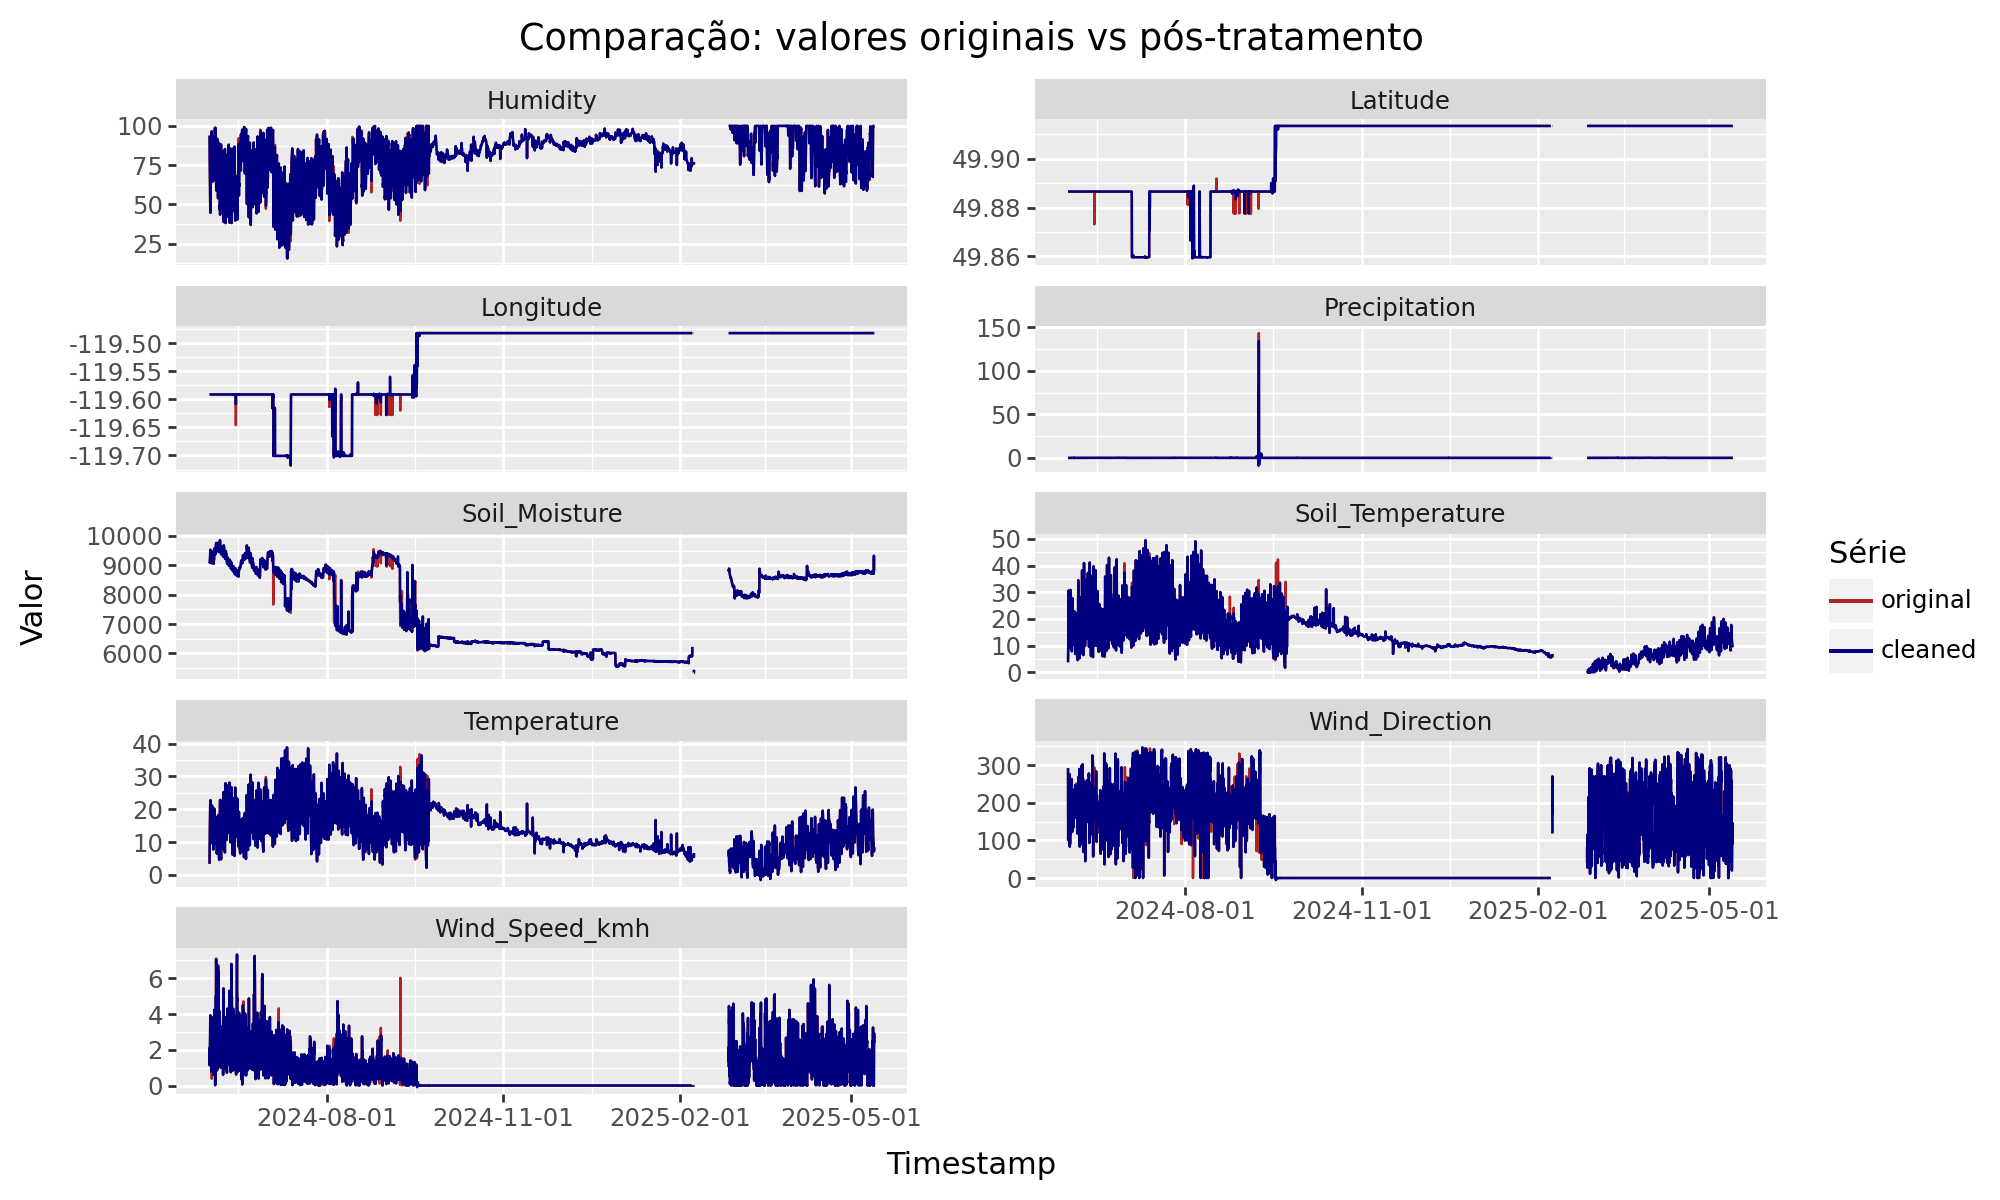

In [13]:
orig_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='original')
)

clean_long = (
    df_clean
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='cleaned')
)

combined = pd.concat([orig_long, clean_long], ignore_index=True)
type_order = CategoricalDtype(['original', 'cleaned'], ordered=True)
combined['type'] = combined['type'].astype(type_order)

plot = (
    ggplot(combined, aes('Timestamp', 'value', color='type'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + scale_color_manual(values=['firebrick', 'navy'])
    + labs(
        title='Comparison: original values vs post-treatment',
        x='Timestamp',
        y='Value',
        color='Series'
    )
    + theme(figure_size=(10, 6))
)

plot.show()

In [14]:
df = df_clean

In [15]:
import xgboost as xgb
df_imputed = df.copy()
colunas_para_imputar = df.columns
df_imputed['hour'] = df_imputed.index.hour
df_imputed['dayofyear'] = df_imputed.index.dayofyear
df_imputed['dayofweek'] = df_imputed.index.dayofweek
df_imputed['month'] = df_imputed.index.month
df_imputed['year'] = df_imputed.index.year
features = [col for col in df_imputed.columns if col not in colunas_para_imputar]
print(f"Features for the XGBoost model: {features}")
for col_target in colunas_para_imputar:
    print(f"\nImputing column: {col_target}")

    # Separate training data and data with NaNs for prediction
    df_train = df_imputed[df_imputed[col_target].notna()]
    df_predict = df_imputed[df_imputed[col_target].isna()]

    if df_predict.empty:
        print(f"No NaNs to impute in {col_target}.")
        continue
    if df_train.empty:
        print(f"No training data for {col_target}.")
        continue

    X_train = df_train[features]
    y_train = df_train[col_target]

    X_predict = df_predict[features]
    if X_train.isnull().any().any():
        print(f"Alert: Found NaNs in TRAINING features for {col_target}. Filling with the mean.")
        for f_col in X_train.columns:
            if X_train[f_col].isnull().any():
                mean_val = X_train[f_col].mean()
                X_train.loc[:, f_col] = X_train[f_col].fillna(mean_val)
                if f_col in X_predict.columns:
                     X_predict.loc[:, f_col] = X_predict[f_col].fillna(mean_val)

    if X_predict.isnull().any().any():
         print(f"Alert: Found NaNs in PREDICTION features for {col_target} that were not filled.")
    print(f"Shape X_train: {X_train.shape}, Shape y_train: {y_train.shape}")
    print(f"Shape X_predict: {X_predict.shape}")
    model = xgb.XGBRegressor(
        objective='reg:squarederror', # For regression
        n_estimators=100,             # Number of trees
        learning_rate=0.1,            # Learning rate
        max_depth=5,                  # Maximum tree depth
        subsample=0.8,                # Fraction of samples to train each tree
        colsample_bytree=0.8,         # Fraction of features to train each tree
        random_state=42,
        # tree_method='hist' # Can speed up training for large datasets
    )
    model.fit(X_train, y_train)
    predicted_values = model.predict(X_predict)
    df_imputed.loc[df_imputed[col_target].isna(), col_target] = predicted_values
    print(f"Total NaNs in {col_target} after imputation: {df_imputed[col_target].isna().sum()}")
    df = df_imputed.drop(columns=['hour', 'dayofyear', 'dayofweek', 'month', 'year'], errors='ignore') # Remove temporal auxiliary columns



Features para o modelo XGBoost: ['hour', 'dayofyear', 'dayofweek', 'month', 'year']

Imputando coluna: Longitude
Shape X_train: (7858, 5), Shape y_train: (7858,)
Shape X_predict: (451, 5)
Total de NaNs em Longitude após imputação: 0

Imputando coluna: Latitude
Shape X_train: (7858, 5), Shape y_train: (7858,)
Shape X_predict: (451, 5)
Total de NaNs em Latitude após imputação: 0

Imputando coluna: Temperature
Shape X_train: (7858, 5), Shape y_train: (7858,)
Shape X_predict: (451, 5)
Total de NaNs em Temperature após imputação: 0

Imputando coluna: Humidity
Shape X_train: (7858, 5), Shape y_train: (7858,)
Shape X_predict: (451, 5)
Total de NaNs em Humidity após imputação: 0

Imputando coluna: Precipitation
Shape X_train: (7858, 5), Shape y_train: (7858,)
Shape X_predict: (451, 5)
Total de NaNs em Precipitation após imputação: 0

Imputando coluna: Wind_Speed_kmh
Shape X_train: (7858, 5), Shape y_train: (7858,)
Shape X_predict: (451, 5)
Total de NaNs em Wind_Speed_kmh após imputação: 0

Imp

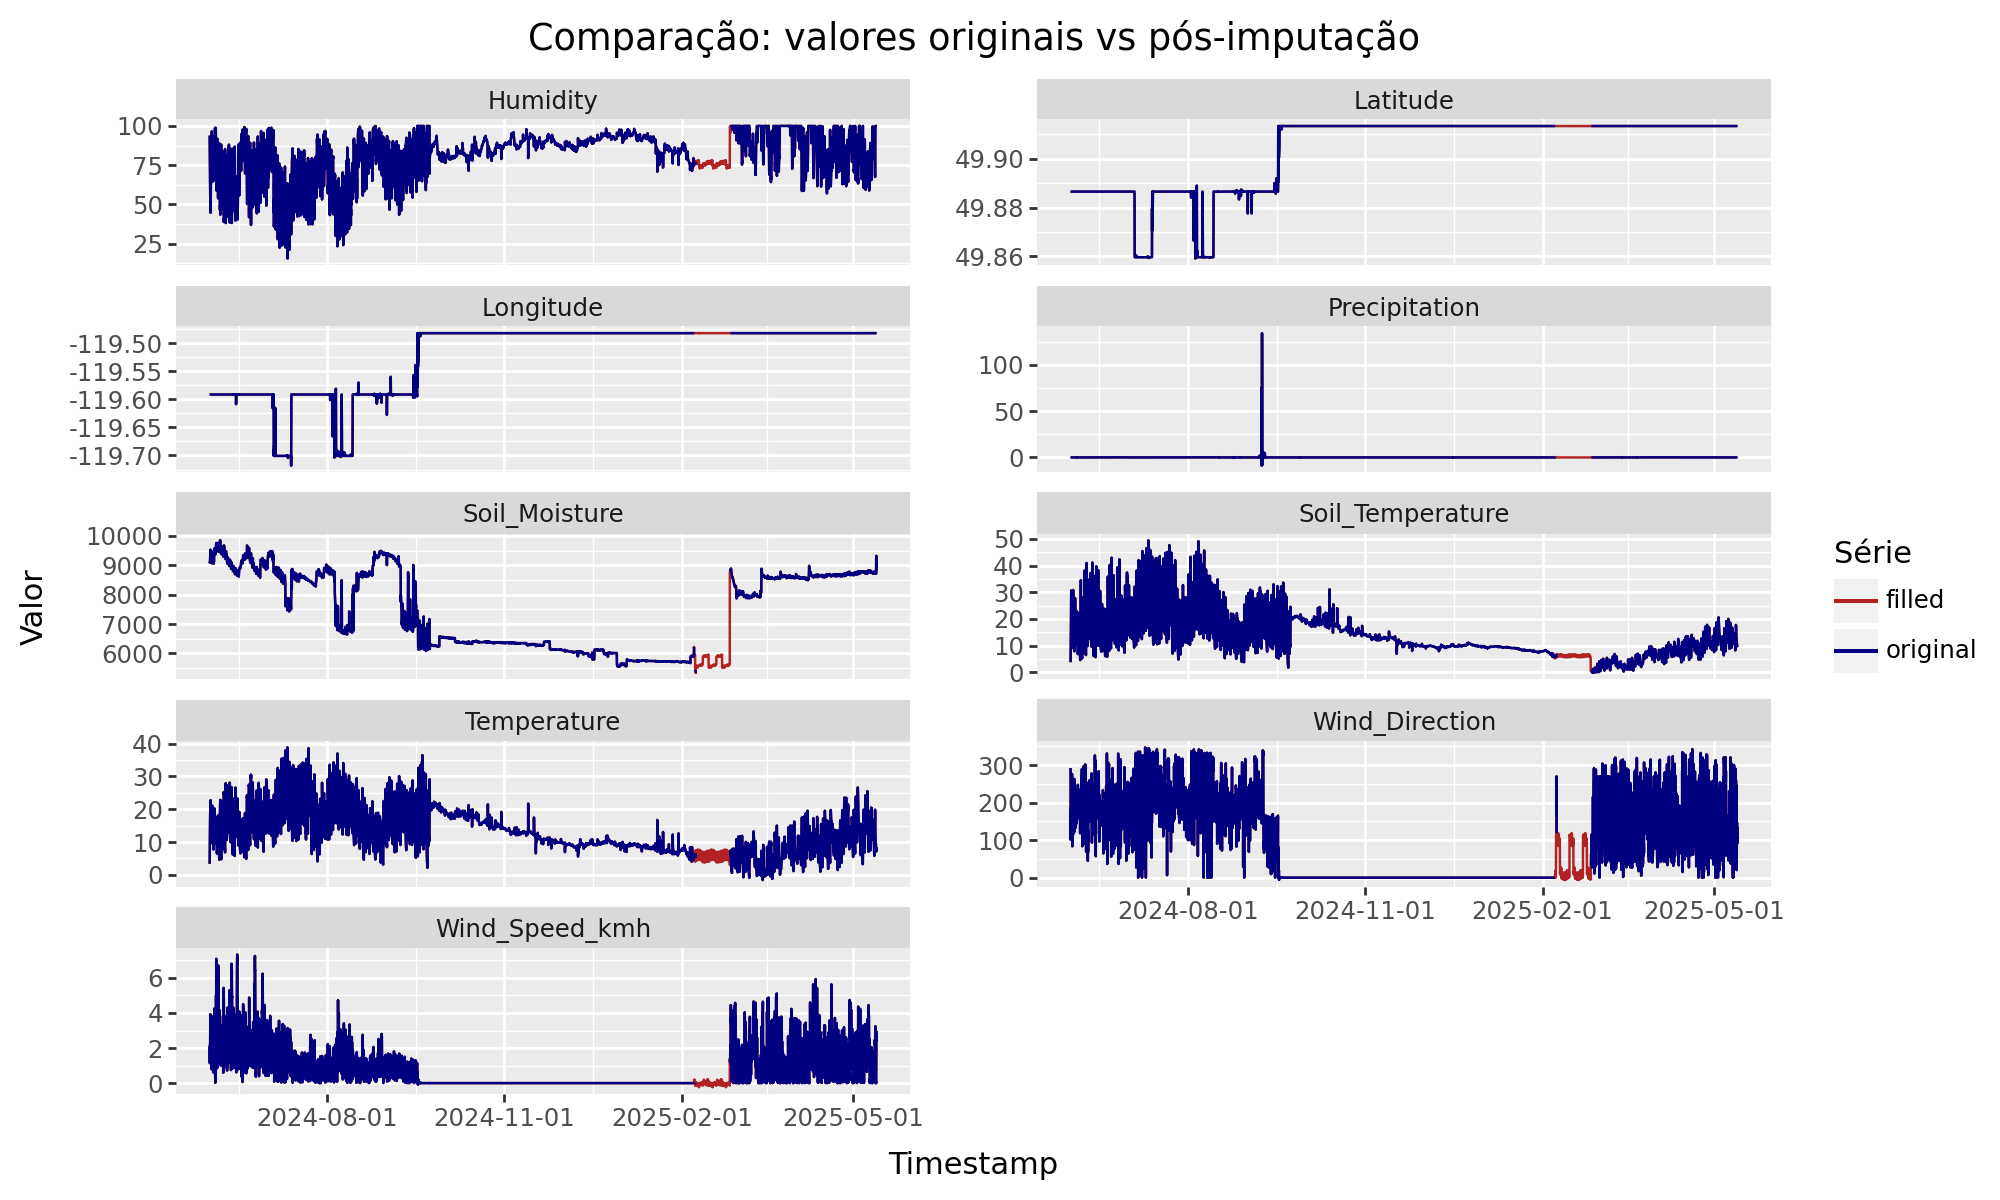

In [16]:
filled_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='filled')
)

clean_long = (
    df_clean
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='original')
)

combined = pd.concat([filled_long, clean_long], ignore_index=True)
type_order = CategoricalDtype(['filled', 'original'], ordered=True)
combined['type'] = combined['type'].astype(type_order)

plot = (
    ggplot(combined, aes('Timestamp', 'value', color='type'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + scale_color_manual(values=['firebrick', 'navy'])
    + labs(
        title='Comparison: original values vs post-imputation',
        x='Timestamp',
        y='Value',
        color='Series'
    )
    + theme(figure_size=(10, 6))
)

plot.show()

In [17]:
# Transform Wind_Direction (because angles 0° and 360° are "equivalent")
df['Wind_Dir_Sin'] = np.sin(np.deg2rad(df['Wind_Direction']))
df['Wind_Dir_Cos'] = np.cos(np.deg2rad(df['Wind_Direction']))

df.drop(columns=['Wind_Direction'], inplace=True)


In [18]:
df['Precipitation_accumulated'] = df['Precipitation'].cumsum()
df.drop(columns=['Precipitation'], inplace=True)

In [19]:
profile = ProfileReport(df, title='Profile Report')
profile.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 393.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
df.to_csv('../data/ground_station_clean.csv', index=True)

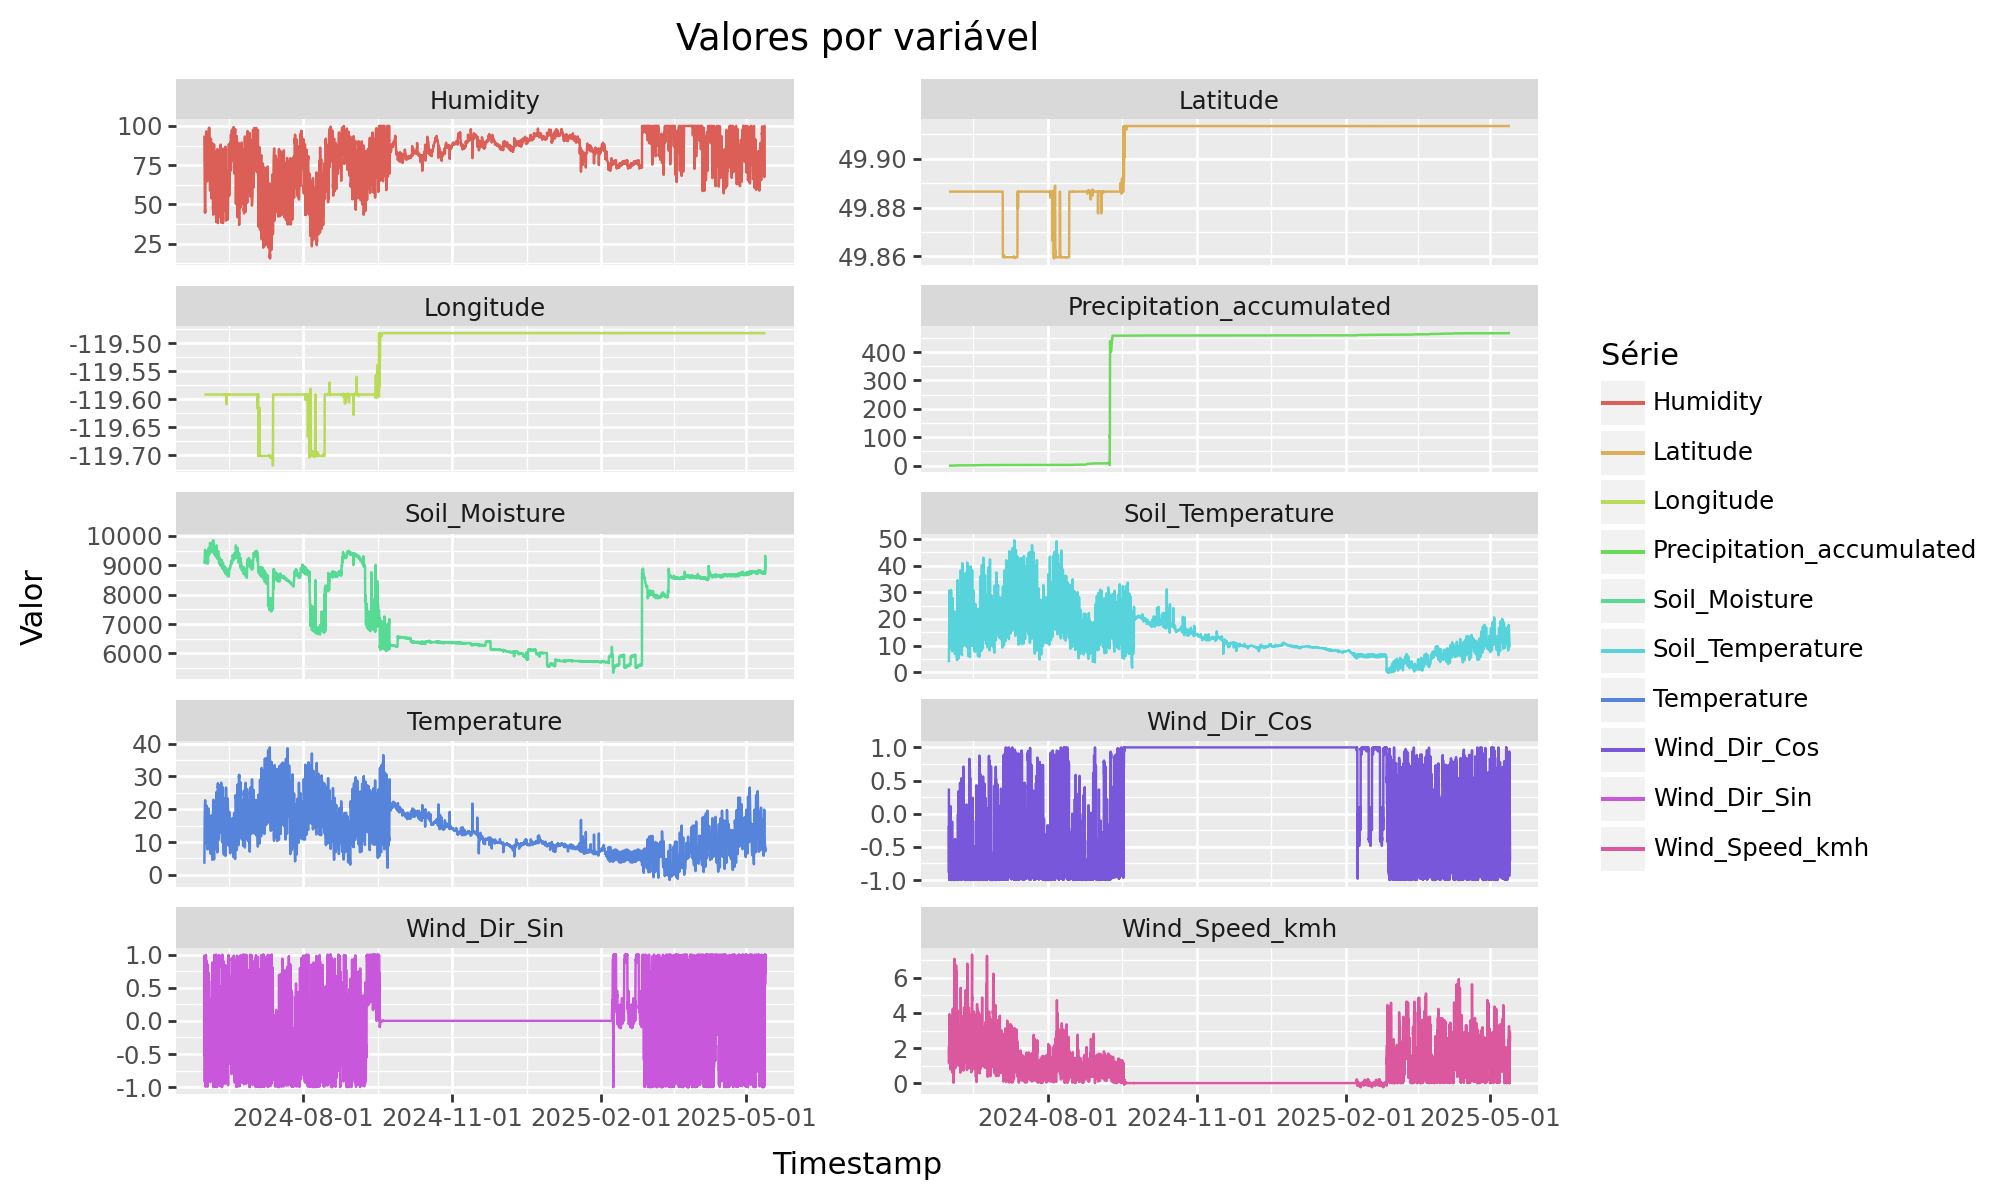

In [22]:
df_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
)


plot = (
    ggplot(df_long, aes('Timestamp', 'value', color='variable'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + labs(
        title='Values by variable',
        x='Timestamp',
        y='Value',
        color='Series'
    )
    + theme(figure_size=(10, 6))
)

plot.show()
